In [64]:
def break_into_sessions(user_events, session_gap_minutes=5, max_sessions=500):
    """
    Break user events into separate sessions based on time gaps
    
    Args:
        user_events: DataFrame with events for a single user
        session_gap_minutes: Minutes of inactivity to consider a new session
    
    Returns:
        List of session DataFrames
    """
    if len(user_events) == 0:
        return []
    
    # Sort by timestamp
    user_events = user_events.sort_values('timestamp_num').copy()
    
    # Calculate time differences in minutes
    user_events['time_diff_minutes'] = user_events['timestamp_num'].diff() / (1000 * 60)
    
    # Identify session breaks (gaps larger than session_gap_minutes)
    session_breaks = user_events['time_diff_minutes'] > session_gap_minutes
    
    # Create session IDs
    user_events['session_id'] = session_breaks.cumsum()
    
    # Split into separate sessions
    sessions = []
    for session_id in user_events['session_id'].unique():
        session_events = user_events[user_events['session_id'] == session_id].copy()
        if len(session_events) >= 2:  # Only include sessions with at least 2 events
            sessions.append(session_events)
            if len(sessions) >= max_sessions:
                print(f"Found {len(sessions)} sessions")
                break
    
    return sessions


def break_into_sessions(user_events, session_gap_minutes=5, max_sessions=500):
    """
    Break user events into separate sessions based on time gaps
    
    Args:
        user_events: DataFrame with events for a single user
        session_gap_minutes: Minutes of inactivity to consider a new session
    
    Returns:
        List of session DataFrames
    """
    if len(user_events) == 0:
        return []
    
    # Sort by timestamp
    user_events = user_events.sort_values('timestamp_num').copy()
    
    # Calculate time differences in minutes
    user_events['time_diff_minutes'] = user_events['timestamp_num'].diff() / (1000 * 60)
    
    # Identify session breaks (gaps larger than session_gap_minutes)
    session_breaks = user_events['time_diff_minutes'] > session_gap_minutes
    
    # Create session IDs
    user_events['session_id'] = session_breaks.cumsum()
    
    # Split into separate sessions
    sessions = []
    for session_id in user_events['session_id'].unique():
        session_events = user_events[user_events['session_id'] == session_id].copy()
        if len(session_events) >= 2:  # Only include sessions with at least 2 events
            sessions.append(session_events)
            if len(sessions) >= max_sessions:
                print(f"Found {len(sessions)} sessions")
                break
    
    return sessions


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
from datetime import datetime

sns.set(style="whitegrid")

def plot_sample_sessions_side_by_side(label, df, num_sessions=2, bucket_ms=100,  save_dir="sessions_plots"):
    """
    Plot sample sessions with event frequency and event count side by side.
    Save each plot to `sample_sessions/` with timestamped filenames.
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Break events into sessions per user
    all_sessions = []
    for user_id, user_events in df.groupby('userId'):
        sessions = break_into_sessions(user_events)
        all_sessions.extend(sessions)

    # Randomly sample sessions
    if len(all_sessions) < num_sessions:
        print(f"Only {len(all_sessions)} sessions available, plotting all of them")
        sample_sessions = all_sessions
    else:
        sample_sessions = random.sample(all_sessions, num_sessions)

    # Global font size settings
    plt.rcParams.update({
        "axes.titlesize": 22,
        "axes.labelsize": 22,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "font.size": 20
    })

    for i, session in enumerate(sample_sessions, 1):
        session = session.sort_values('timestamp_num')
        session_start = session['timestamp_num'].min()
        session_end = session['timestamp_num'].max()
        session_duration = session_end - session_start

        # Create 100ms bins
        bins = np.arange(0, session_duration + bucket_ms, bucket_ms)
        session['time_from_start'] = session['timestamp_num'] - session_start
        session['time_bin'] = pd.cut(session['time_from_start'], bins, right=False)

        # Frequency per bucket
        freq_per_bin = session.groupby('time_bin').size()
        freq_x = np.arange(len(freq_per_bin))

        # Event counts
        event_counts = session['eventName'].value_counts()

        # Plotting side by side
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f"Sample Session (User: {session['userId'].iloc[0]})", fontsize=22, fontweight='bold')

        # Left subplot: frequency per 100ms
        axs[0].step(freq_x, freq_per_bin.values, where='mid', color='tab:blue', linewidth=3)
        axs[0].set_xlabel('100ms Buckets from Session Start')
        axs[0].set_ylabel('Number of Events')
        axs[0].set_title('Event Frequency per 100ms')
        # axs[0].tick_params(axis='both')

        axs[0].grid(True, linestyle='--', alpha=0.6)

        # Right subplot: event counts
        colors = sns.color_palette('Set2', n_colors=len(event_counts))
        bars = axs[1].bar(event_counts.index, event_counts.values, color=colors, edgecolor='black')
        axs[1].set_xlabel('Event Name')
        axs[1].set_ylabel('Count')
        axs[1].set_title('Number of Each Event')
        axs[1].tick_params(axis='x', rotation=90)
        axs[1].grid(axis='y', linestyle='--', alpha=0.6)

        # Add numbers on top of bars
        axs[1].bar_label(bars, padding=6, fontsize=15, fontweight='bold')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Save with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        user_id = session['userId'].iloc[0]
        # filename = f"{save_dir}/{label}_session_{i}_user_{user_id}_{timestamp}.png"
        # plt.savefig(filename, bbox_inches='tight', dpi=300)
        # plt.close(fig)
        plt.show()

        # print(f"✅ Saved: {filename}")


/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


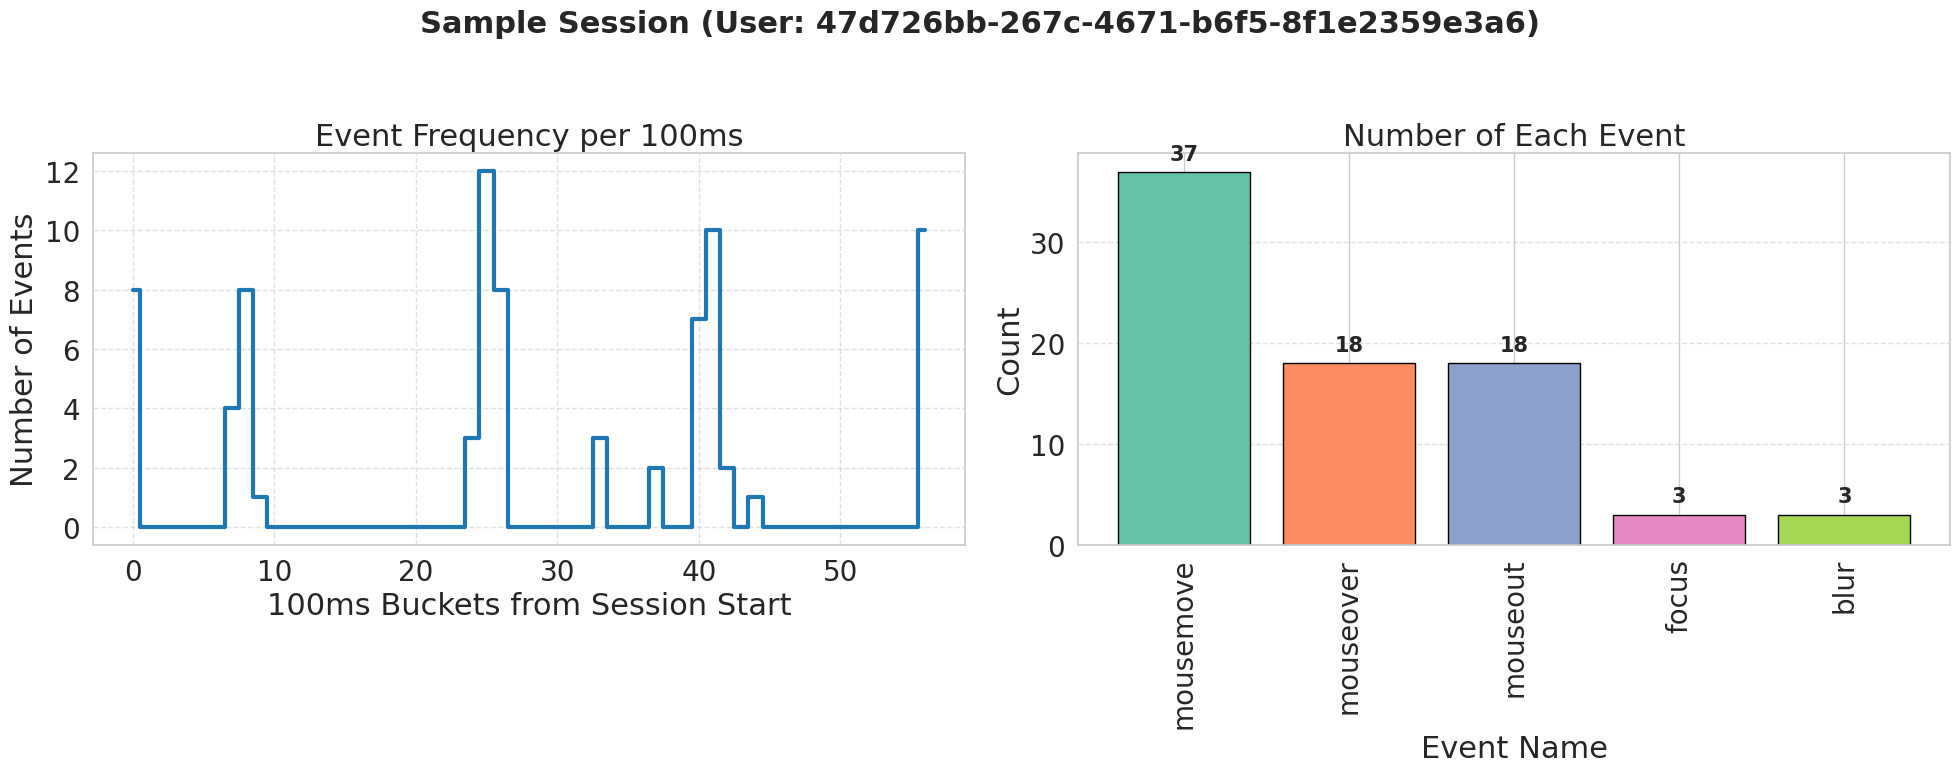

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


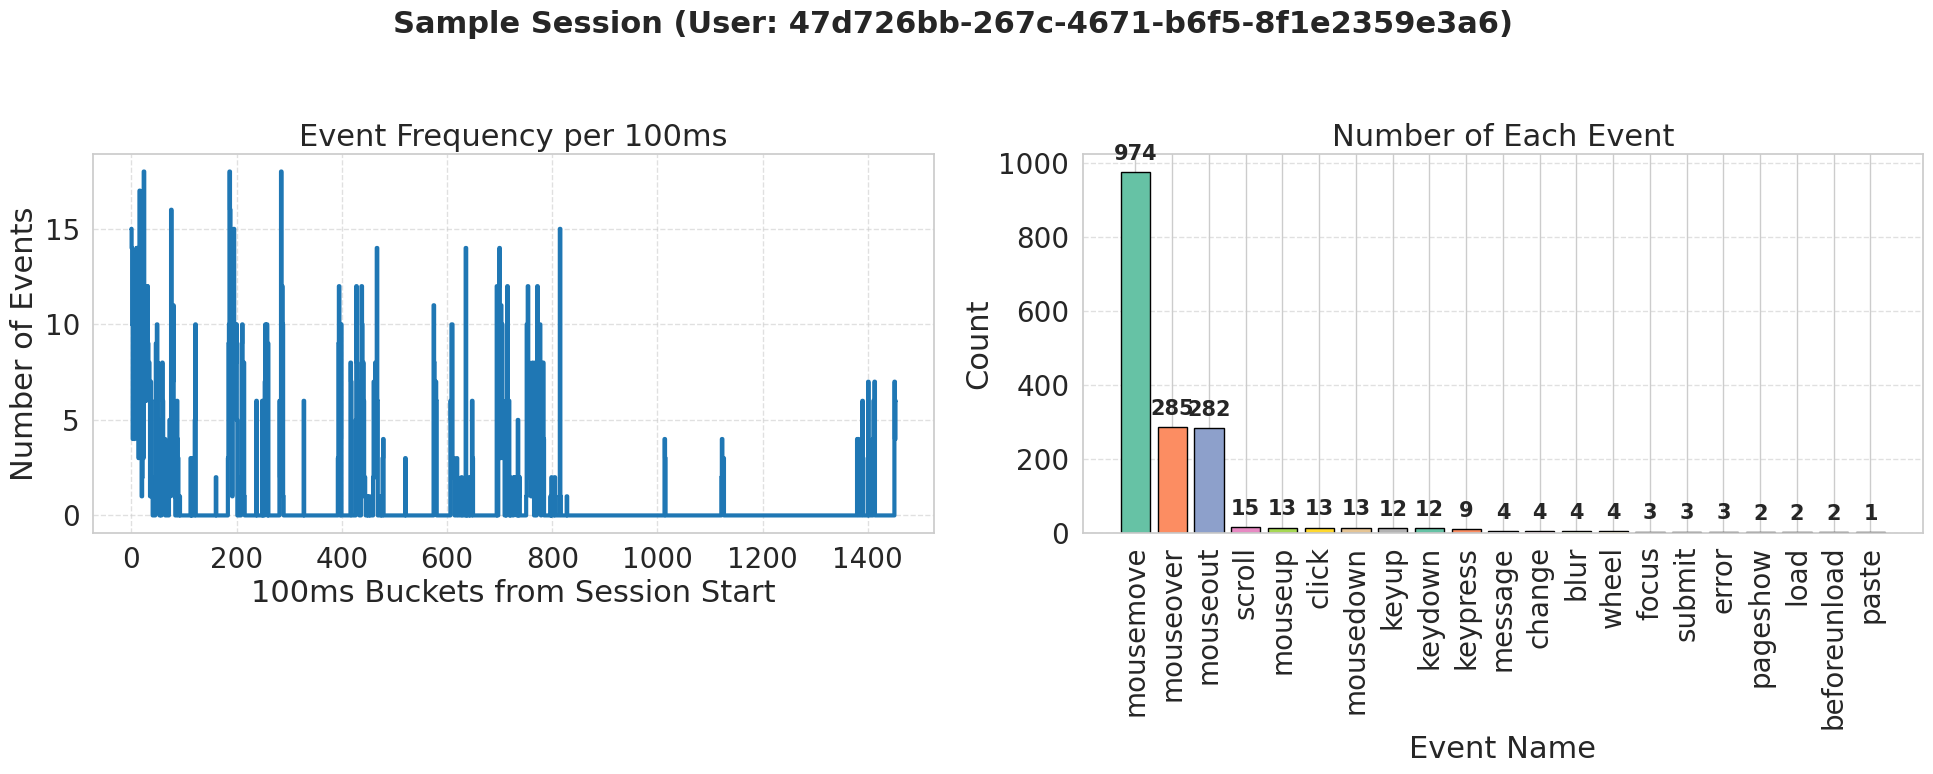

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


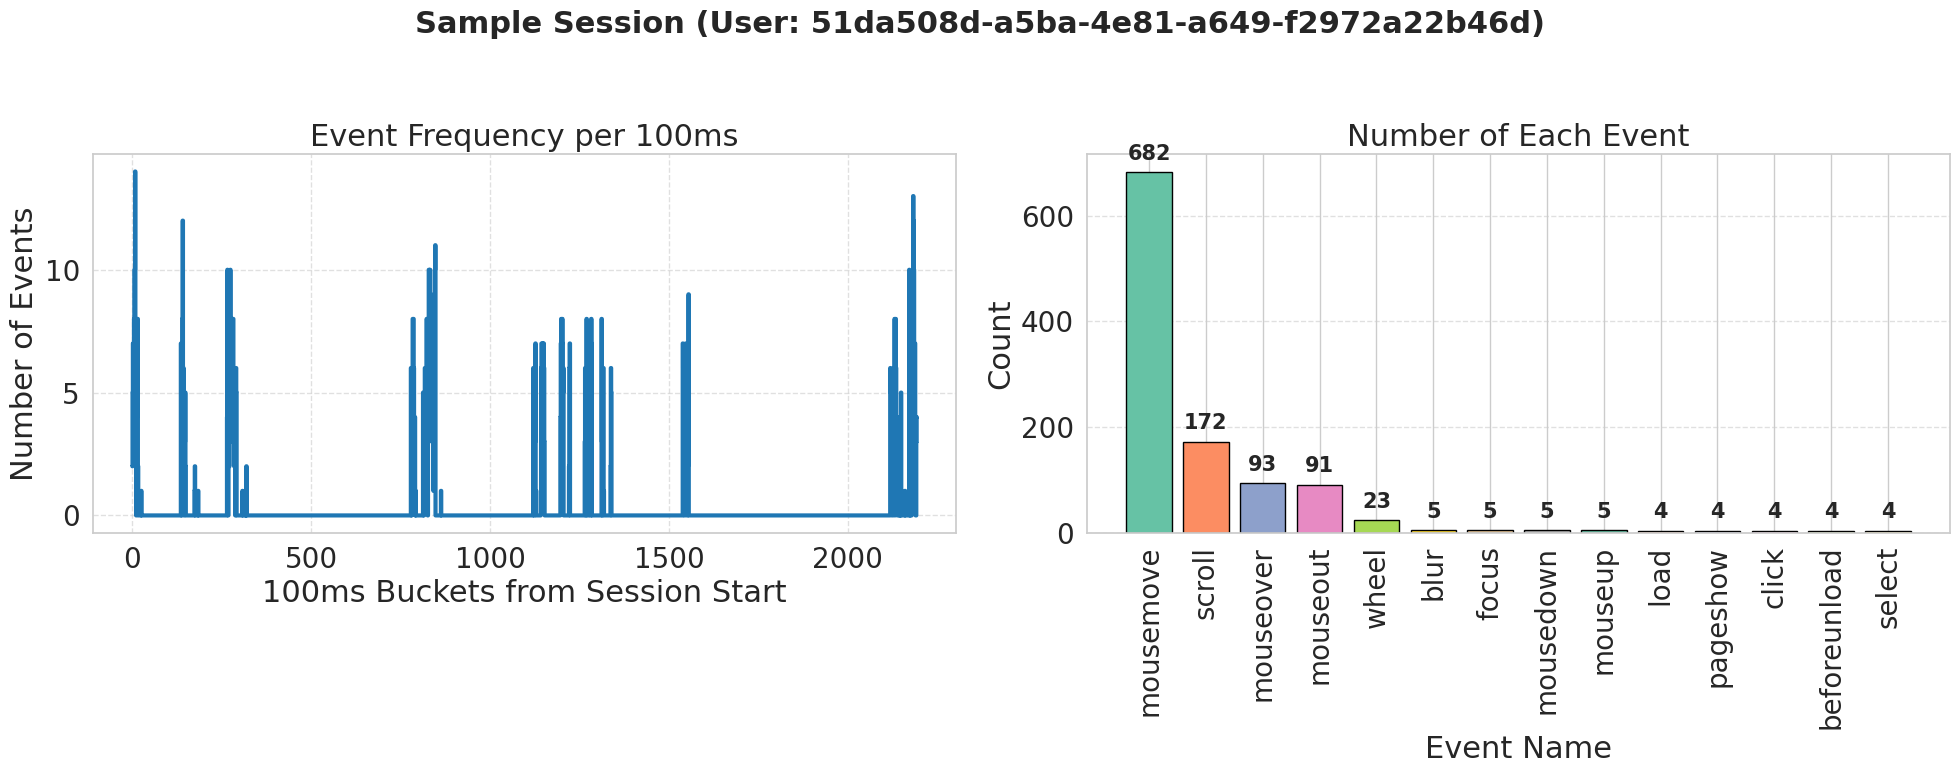

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


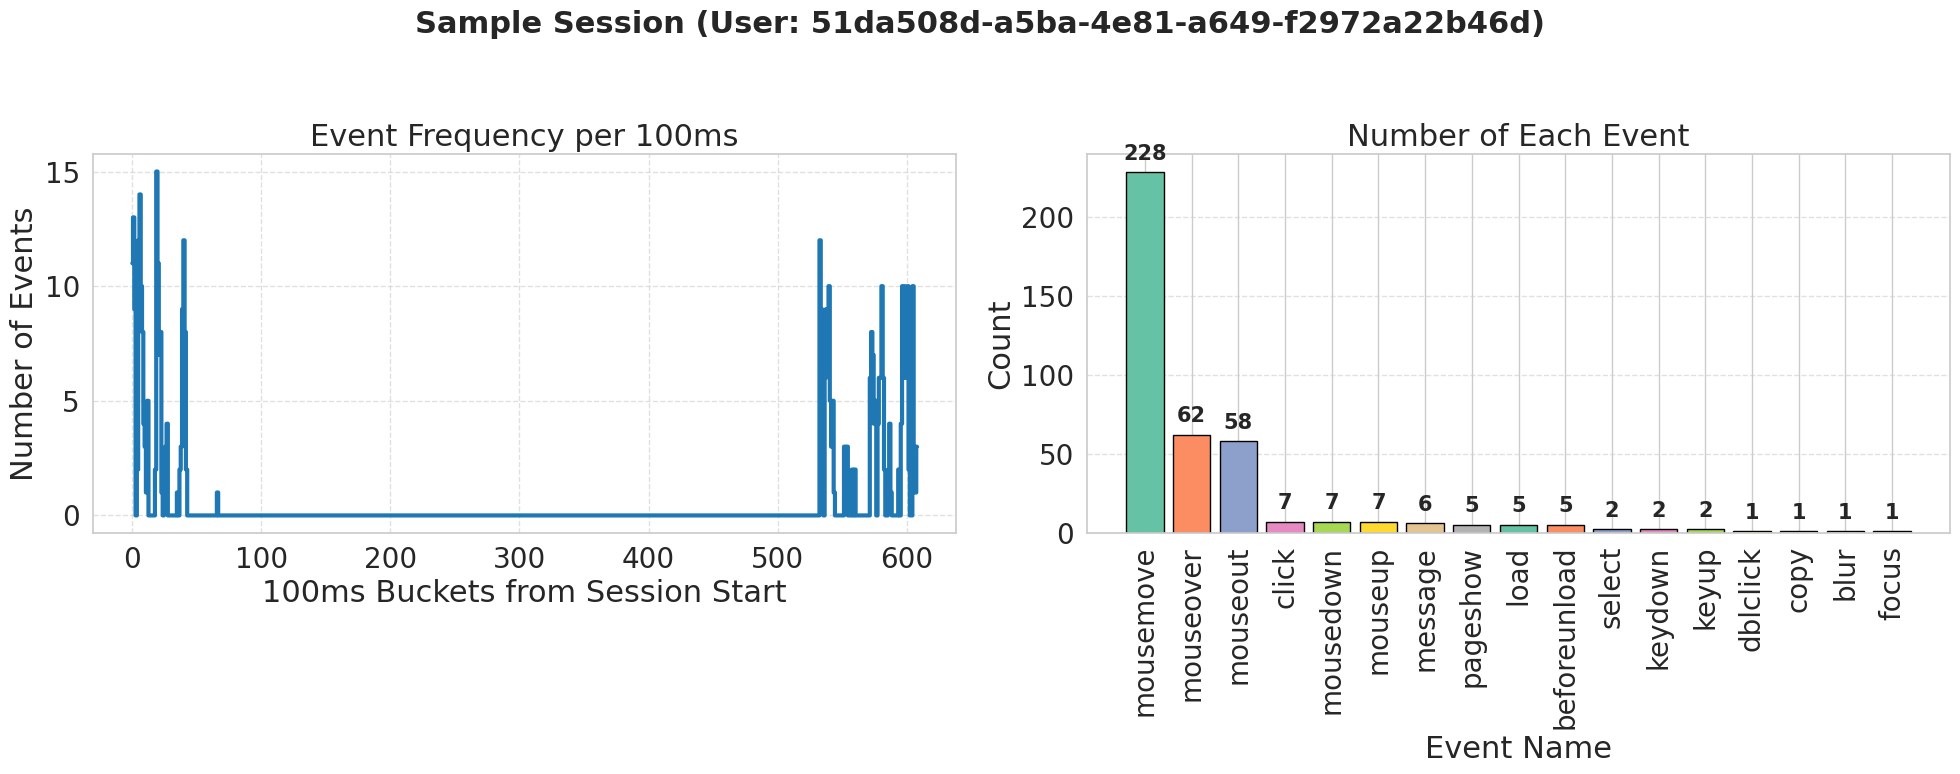

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


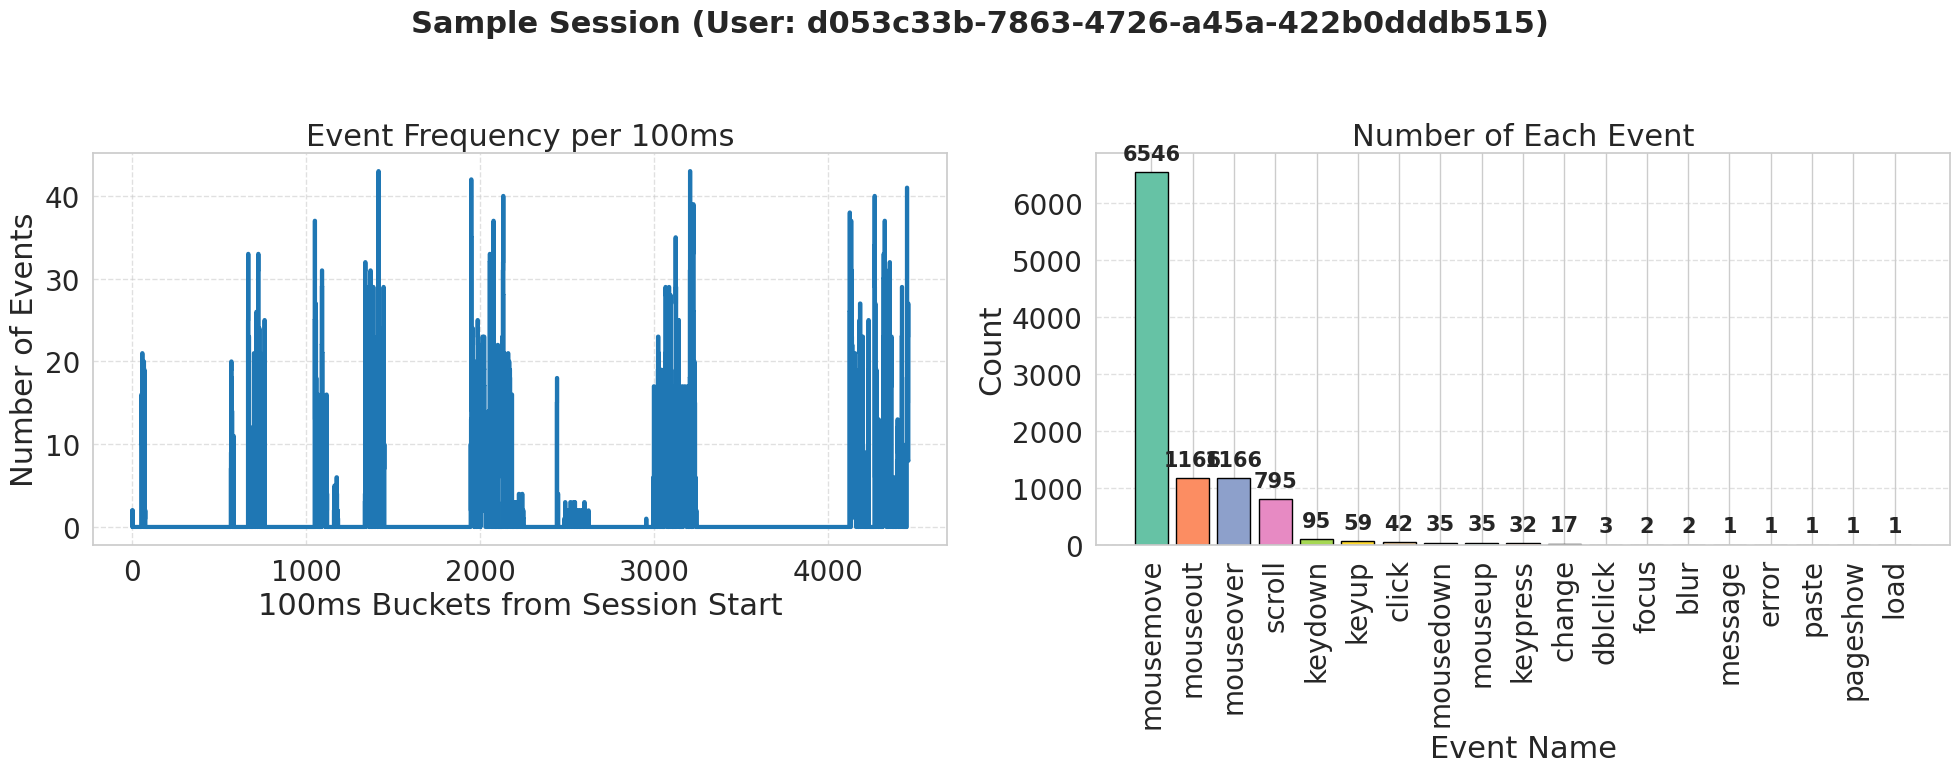

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


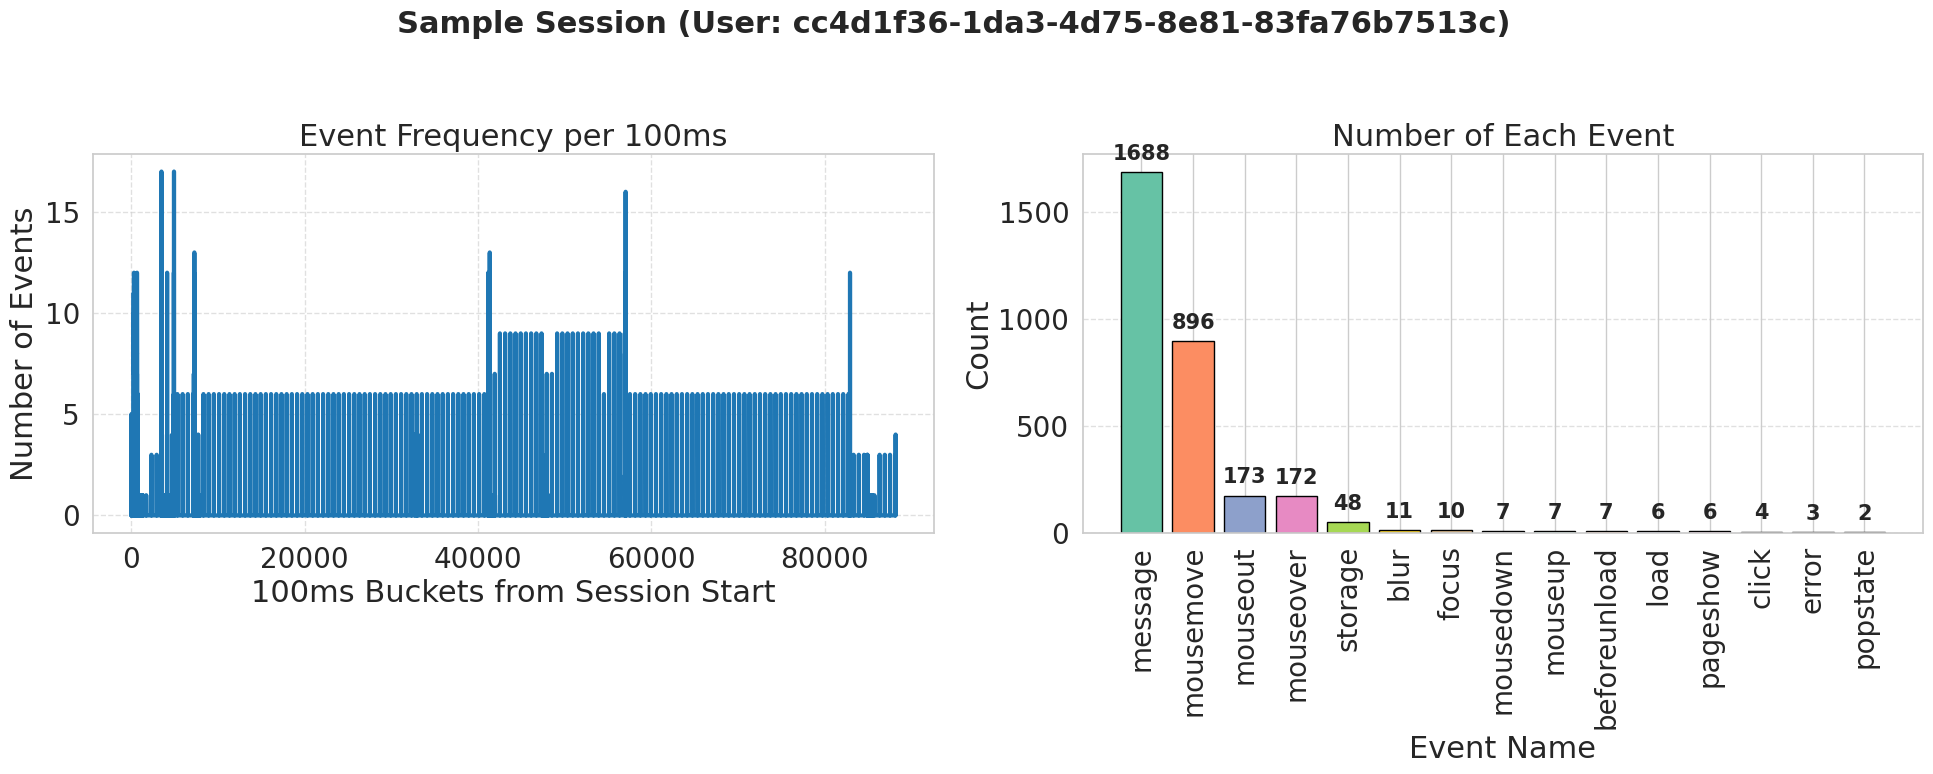

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


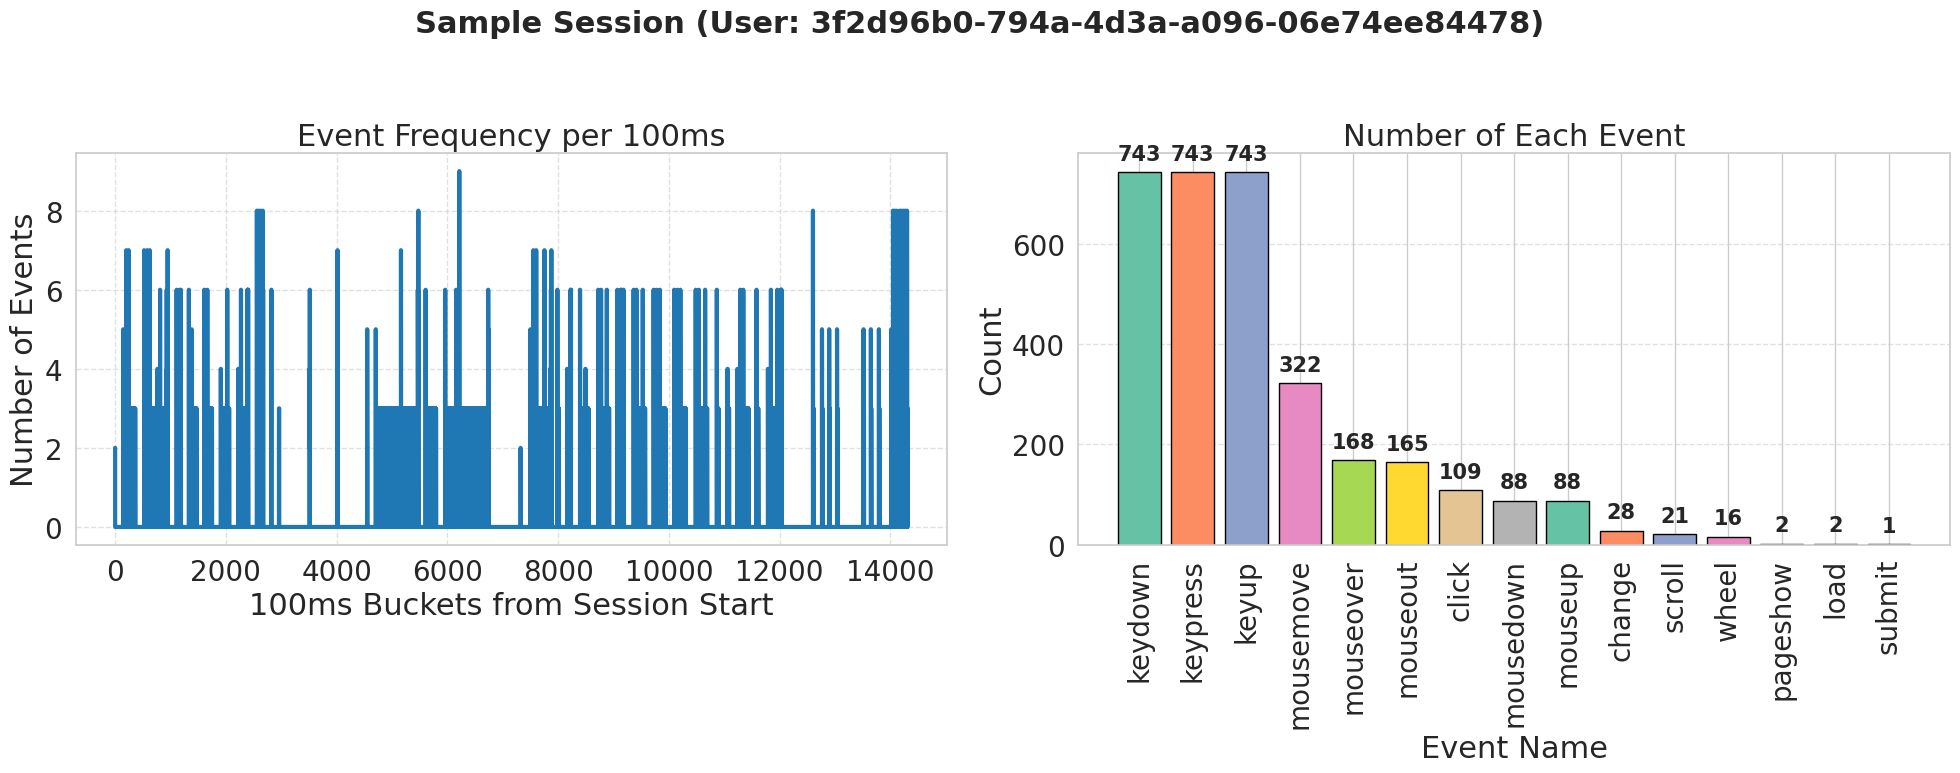

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


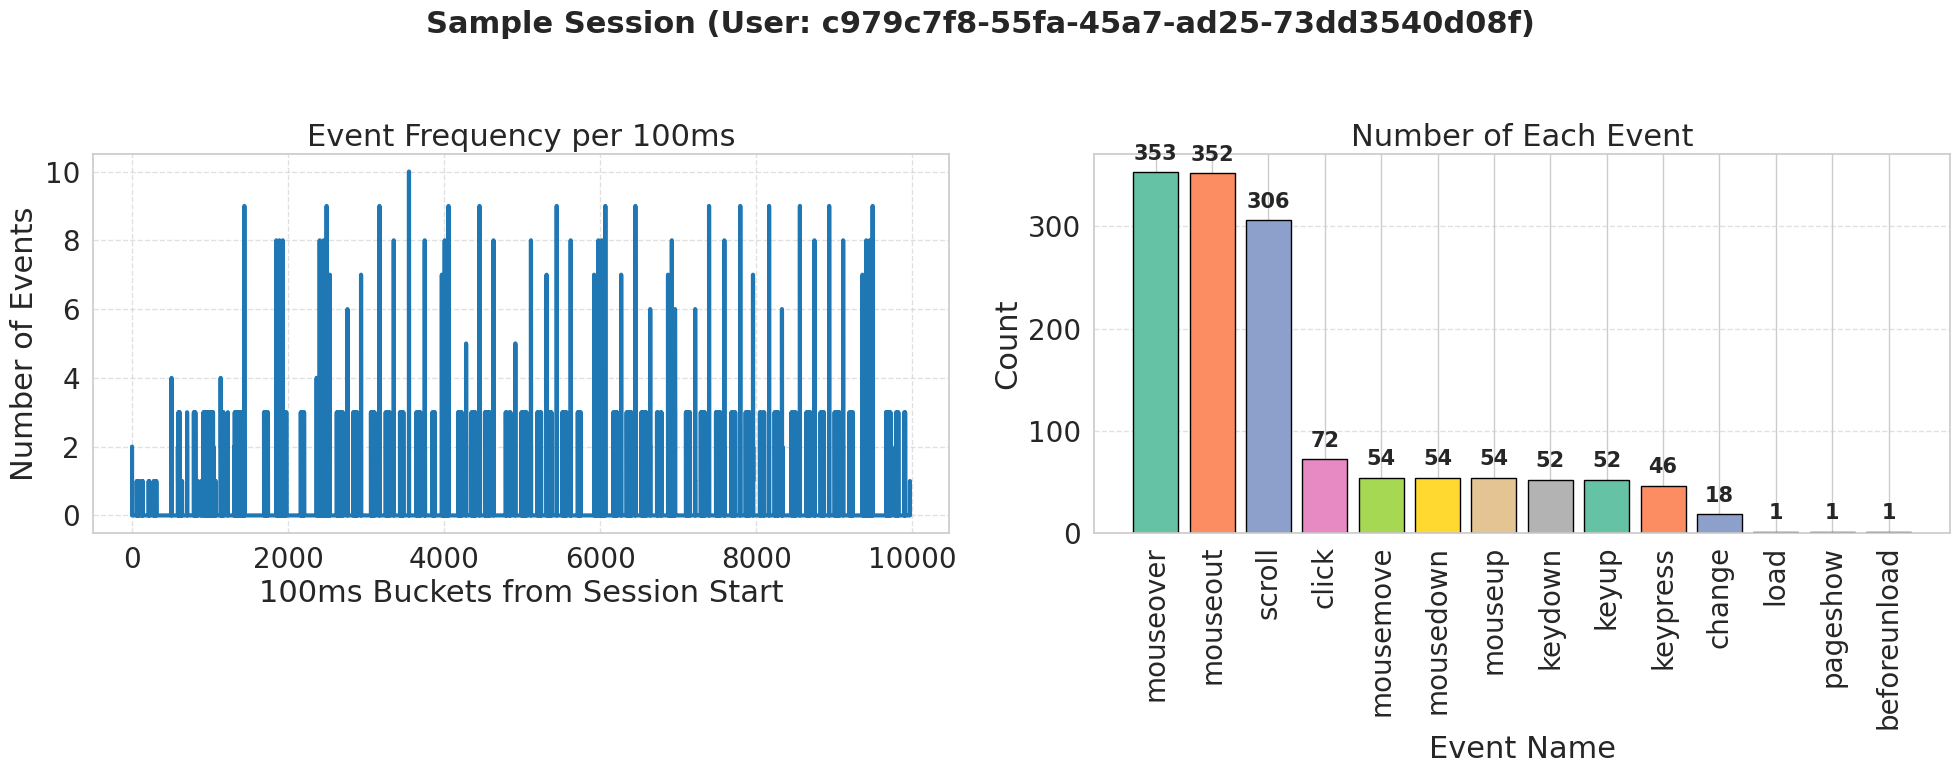

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


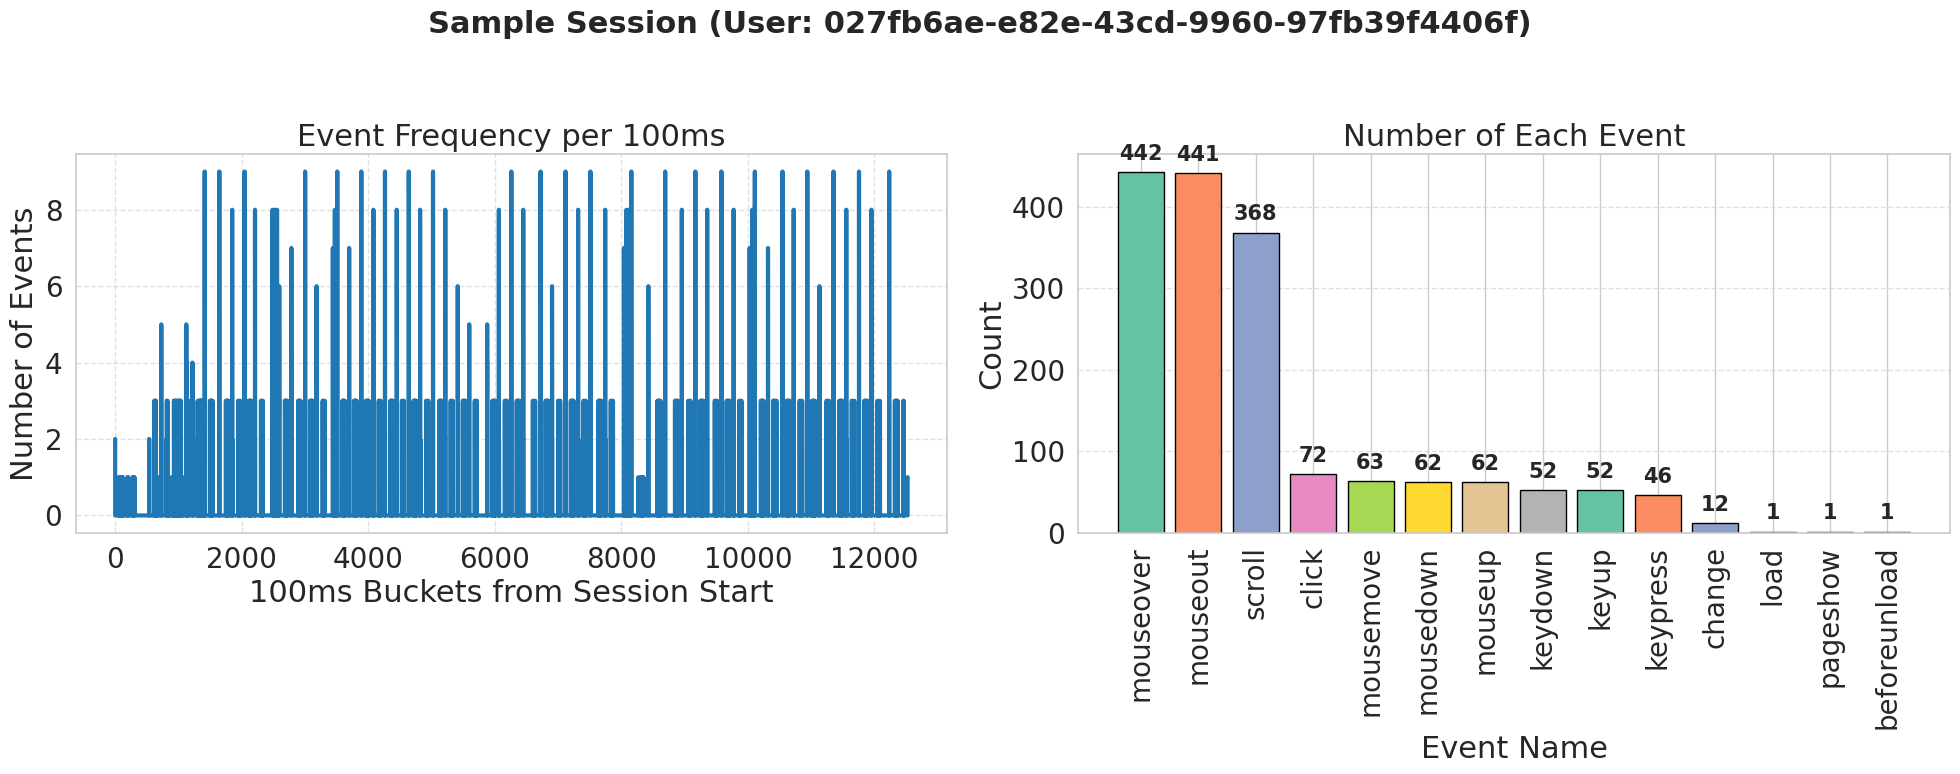

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


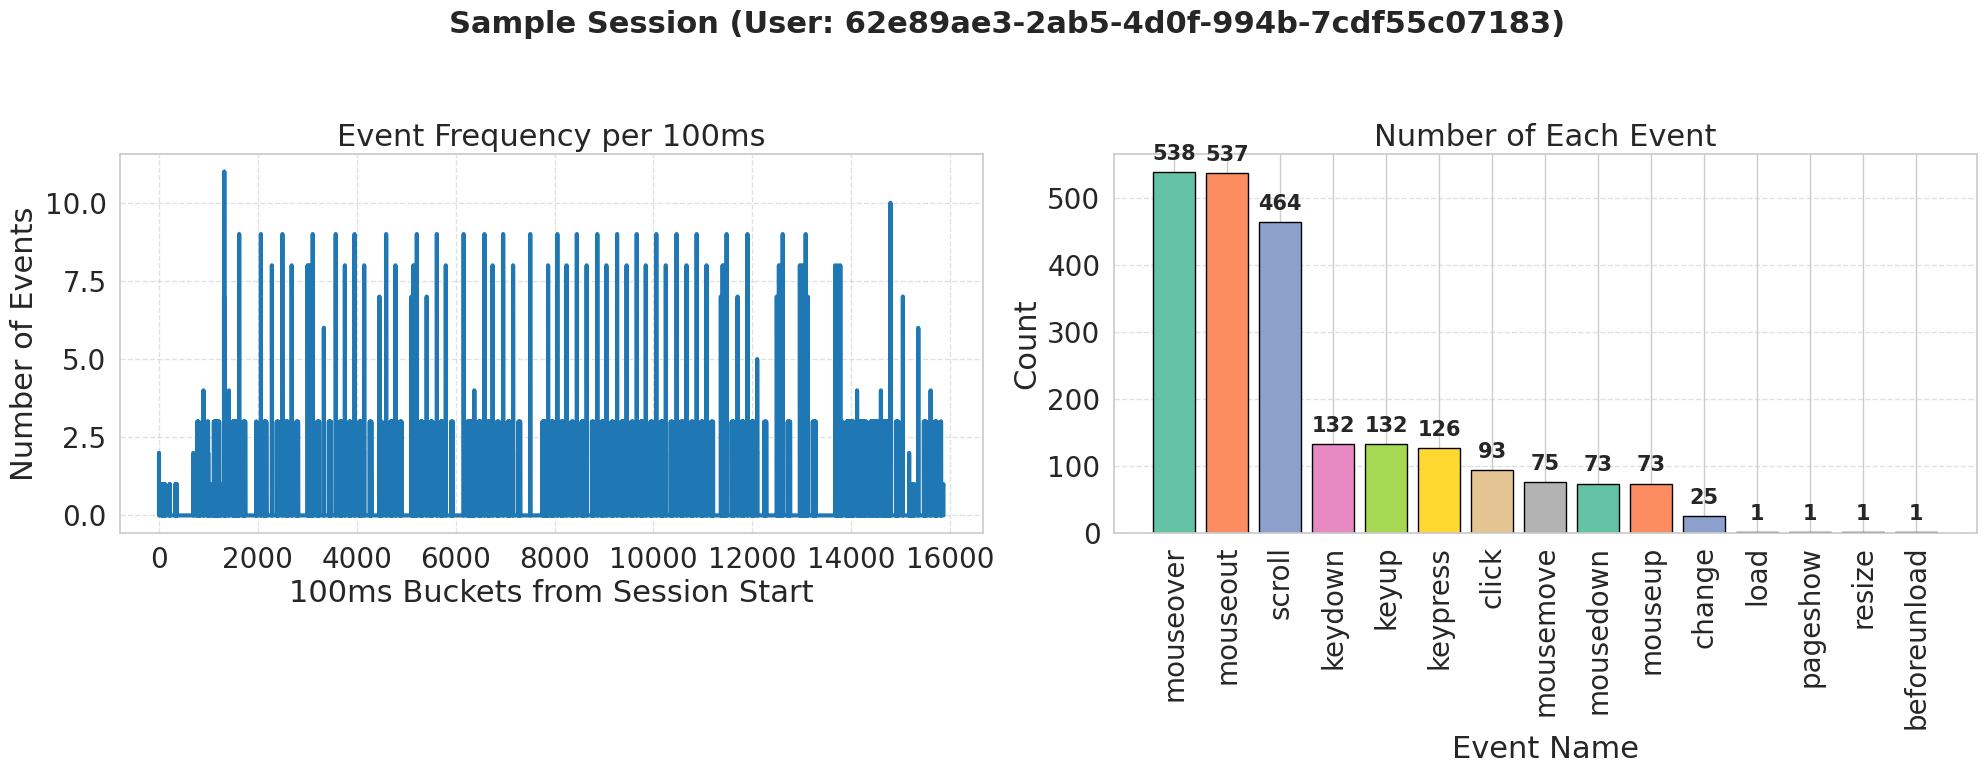

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


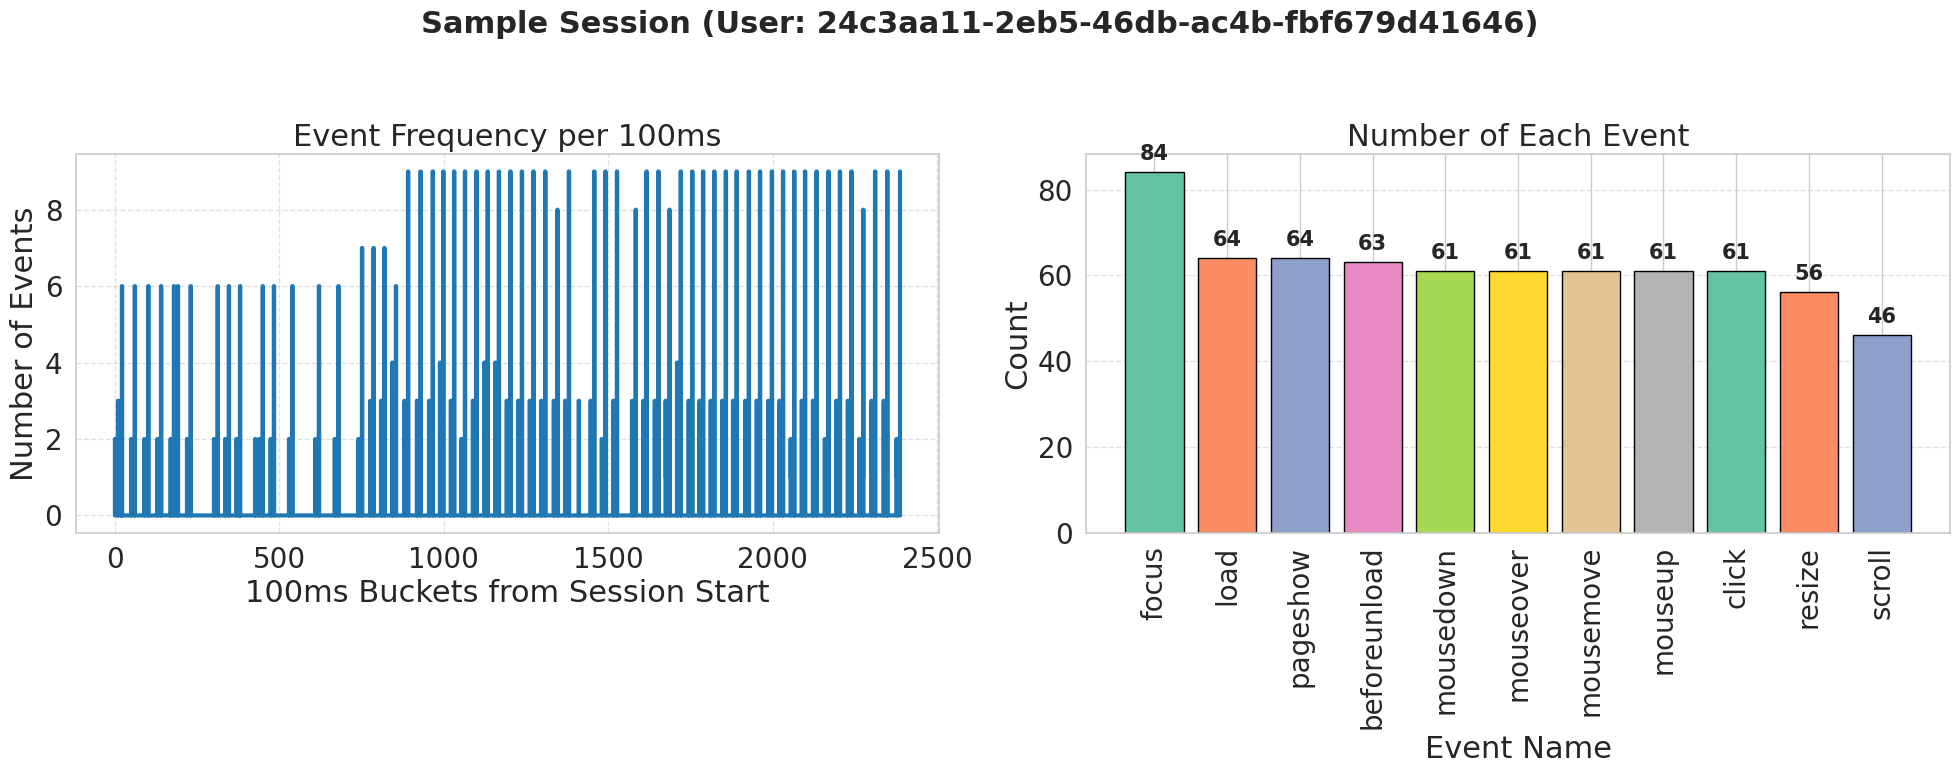

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


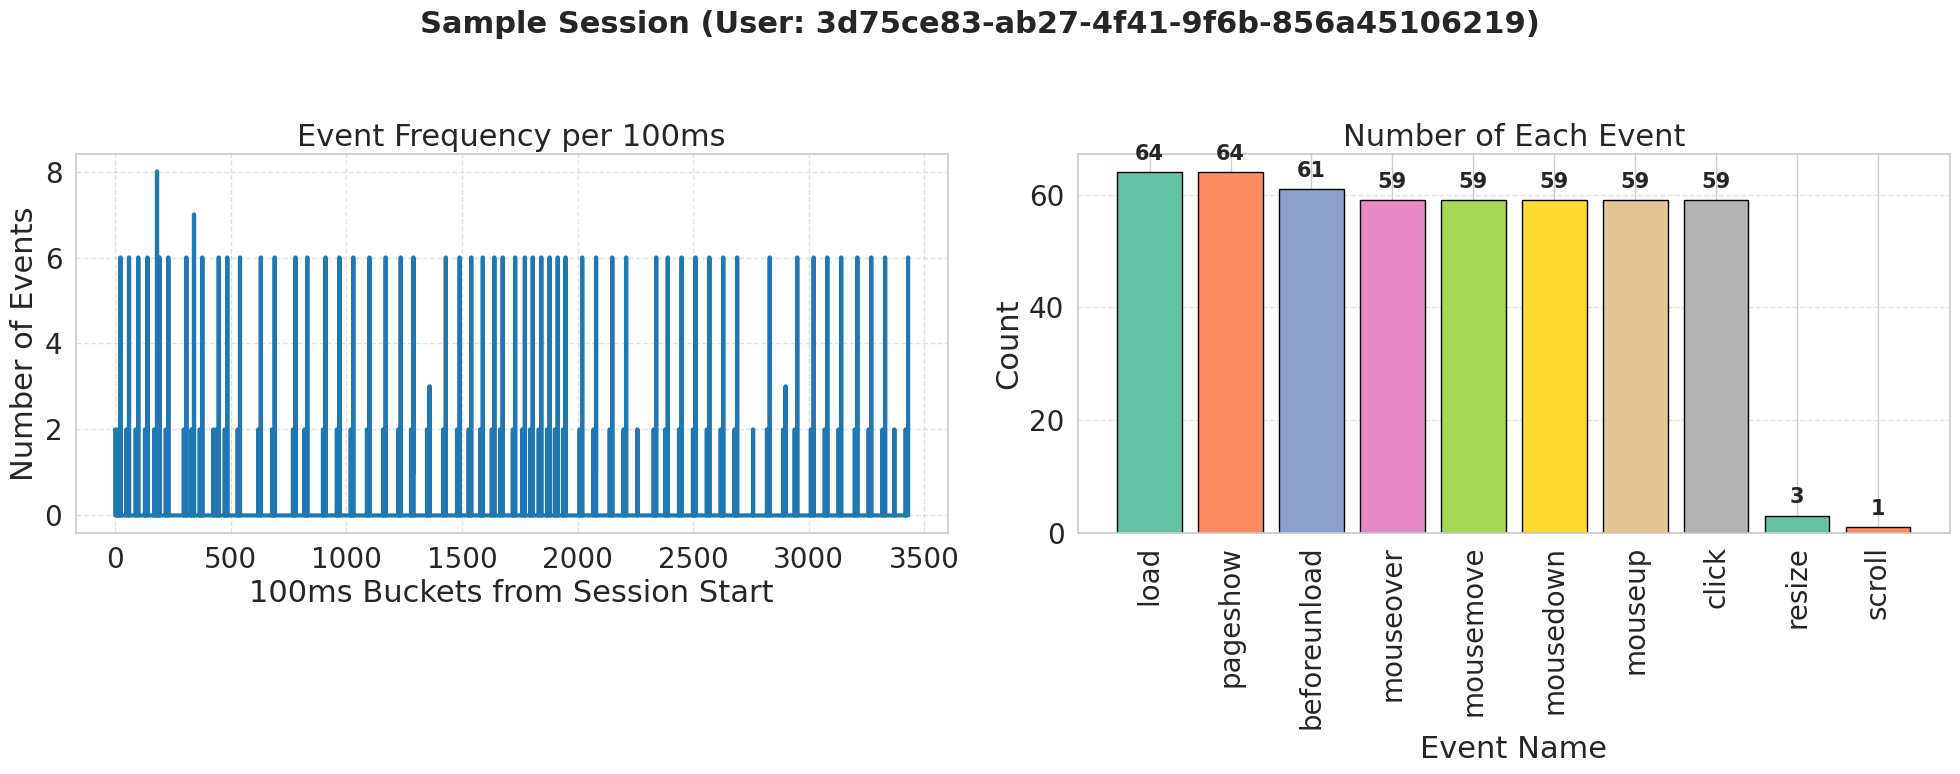

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


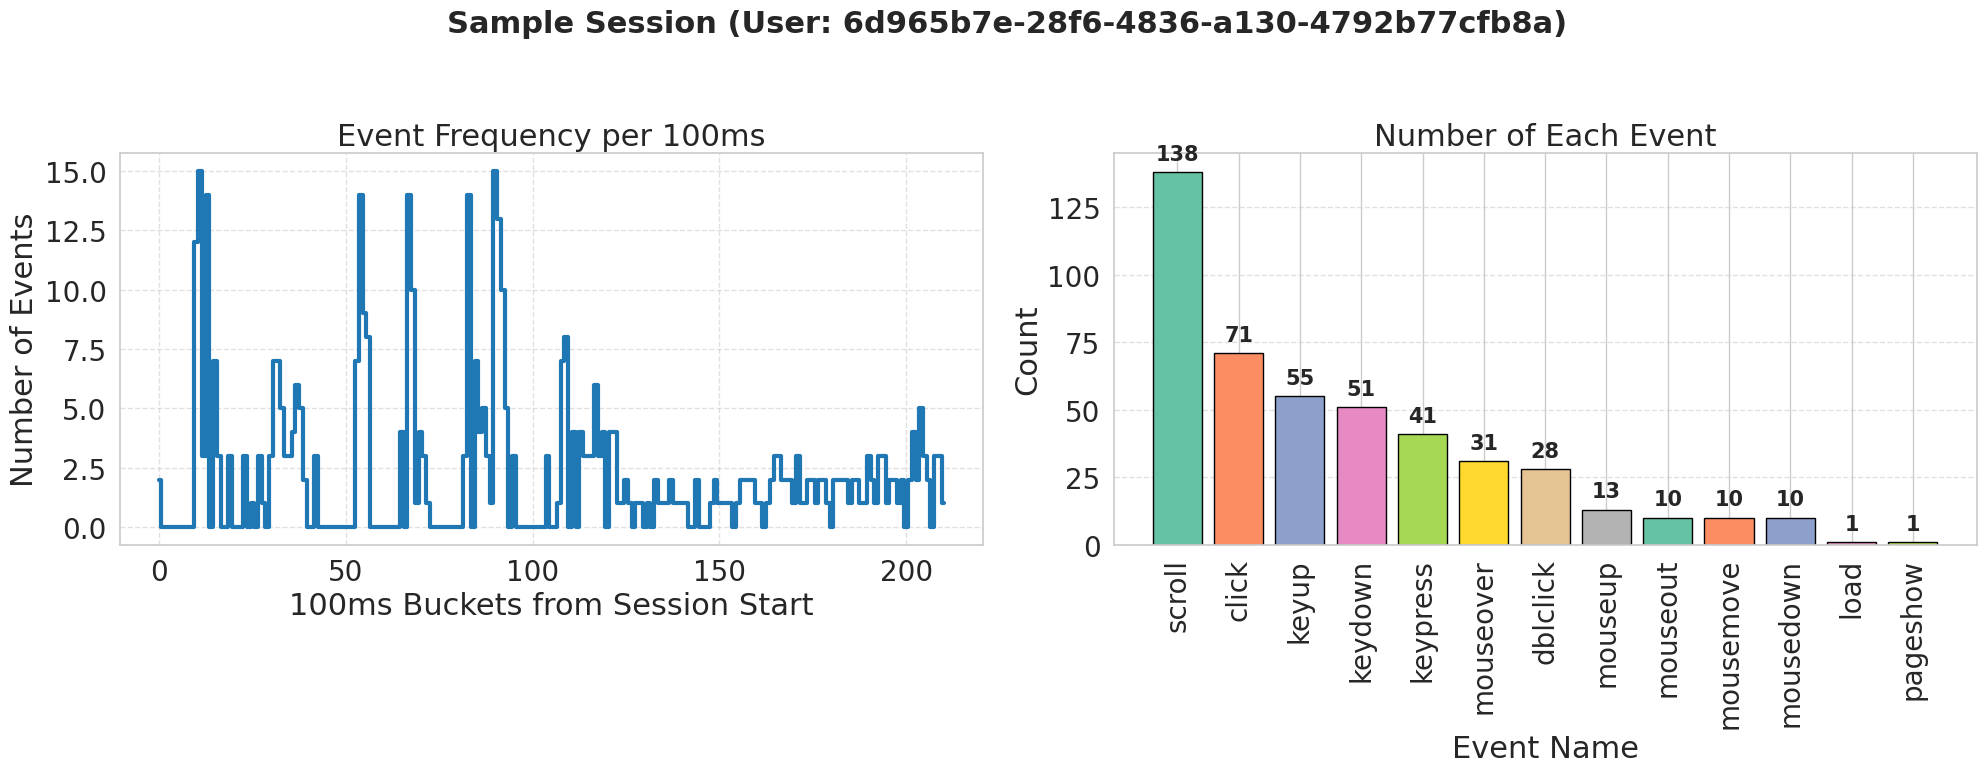

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


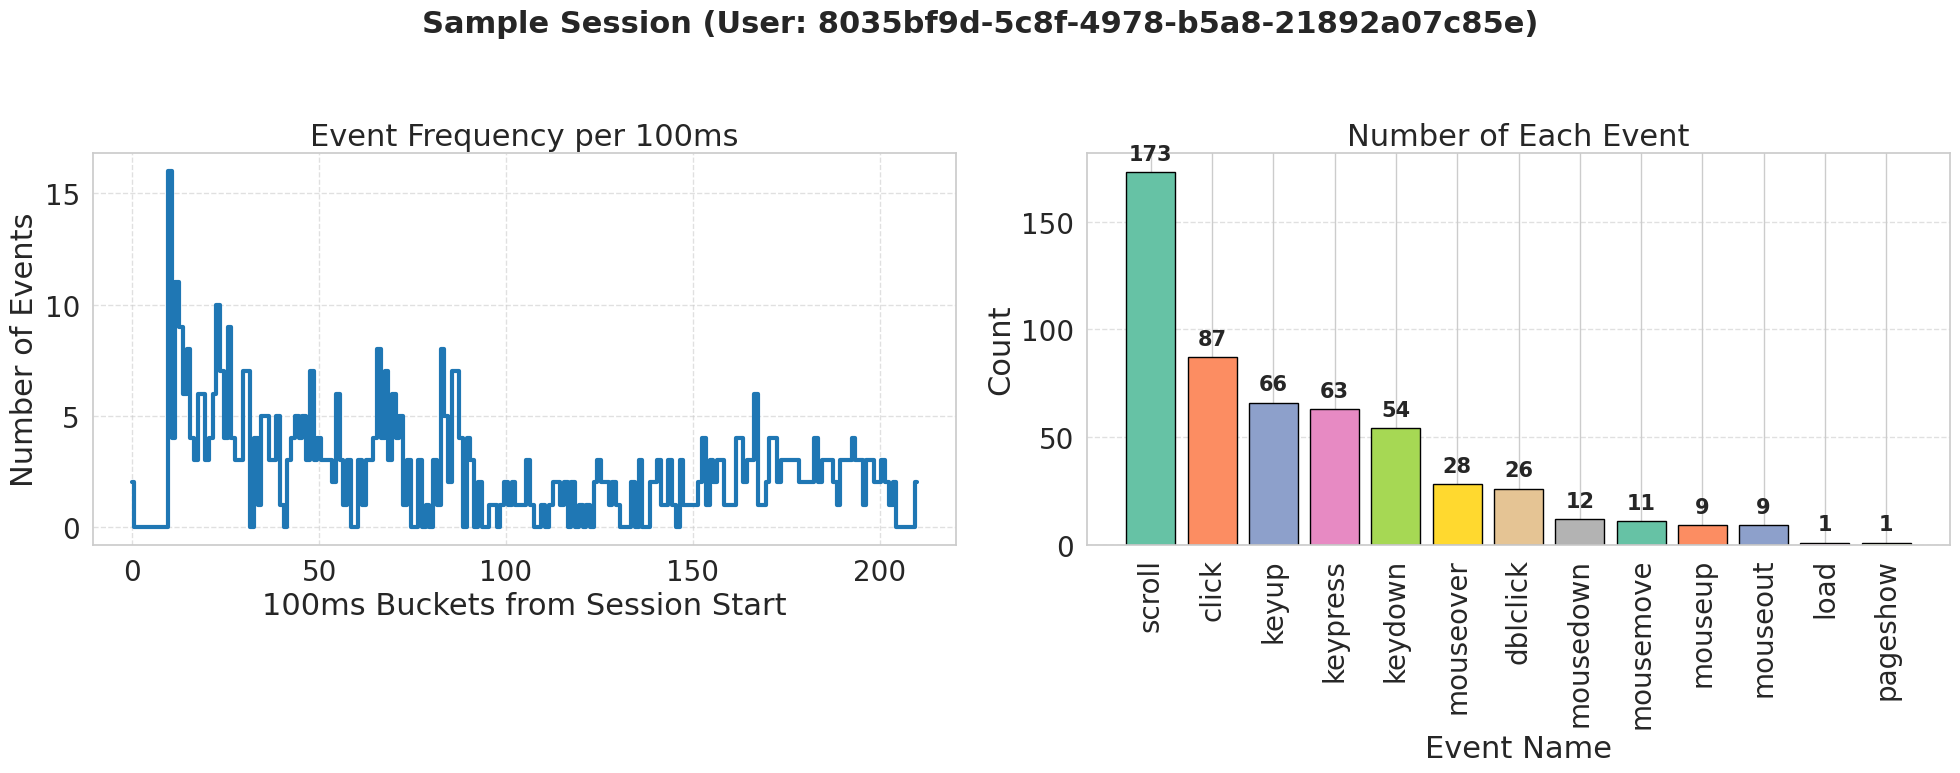

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


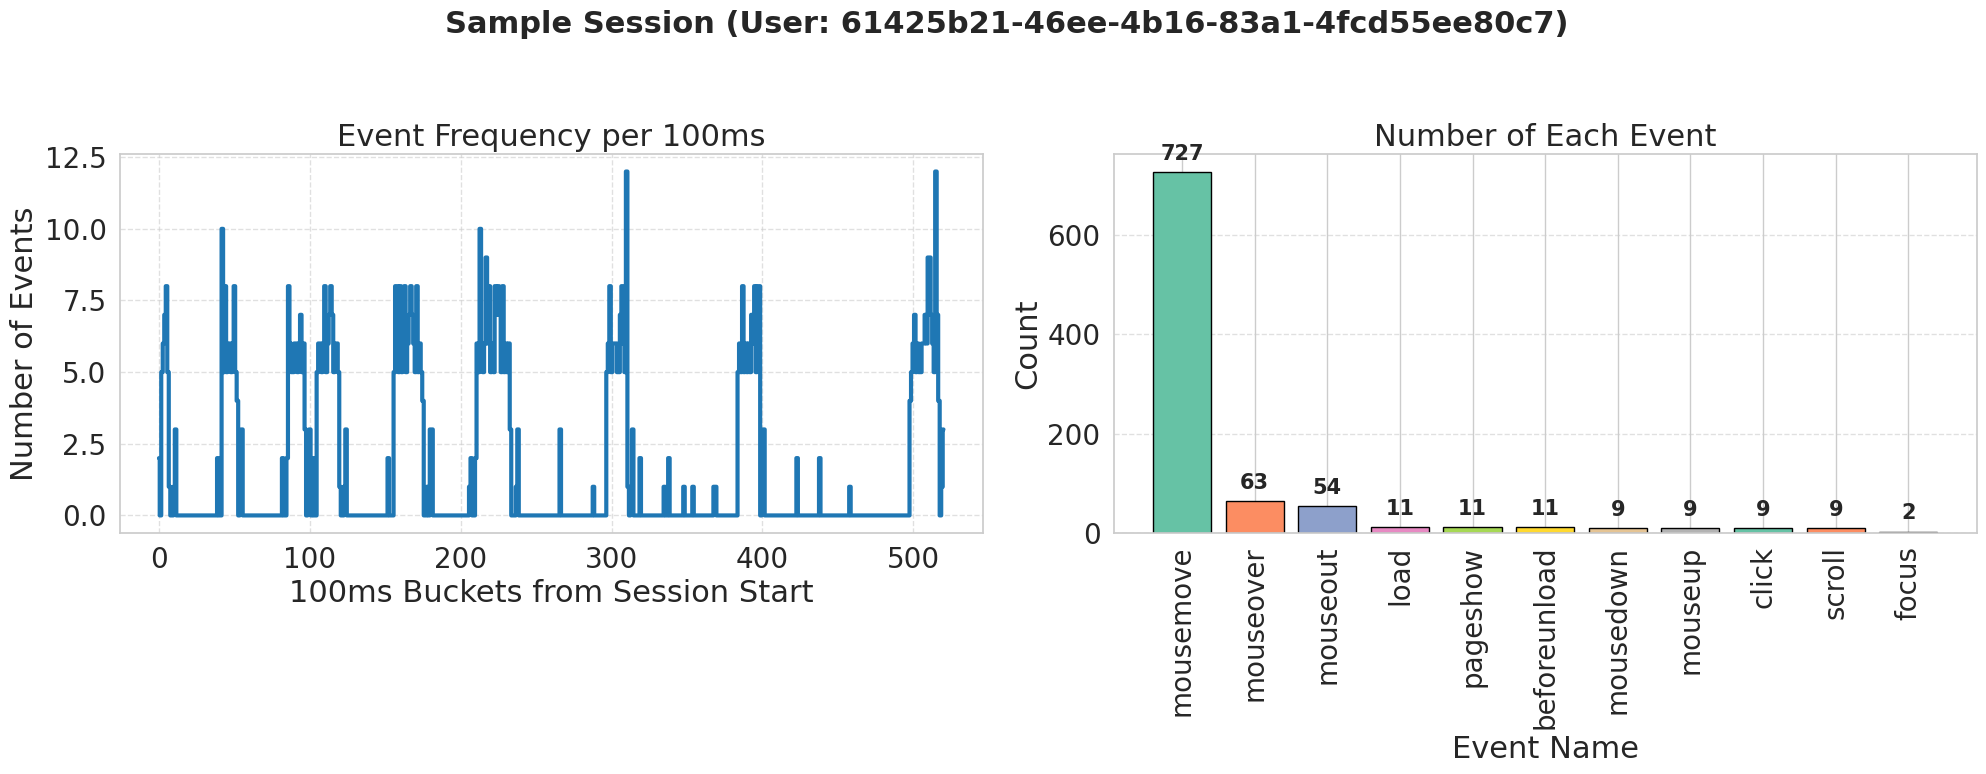

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


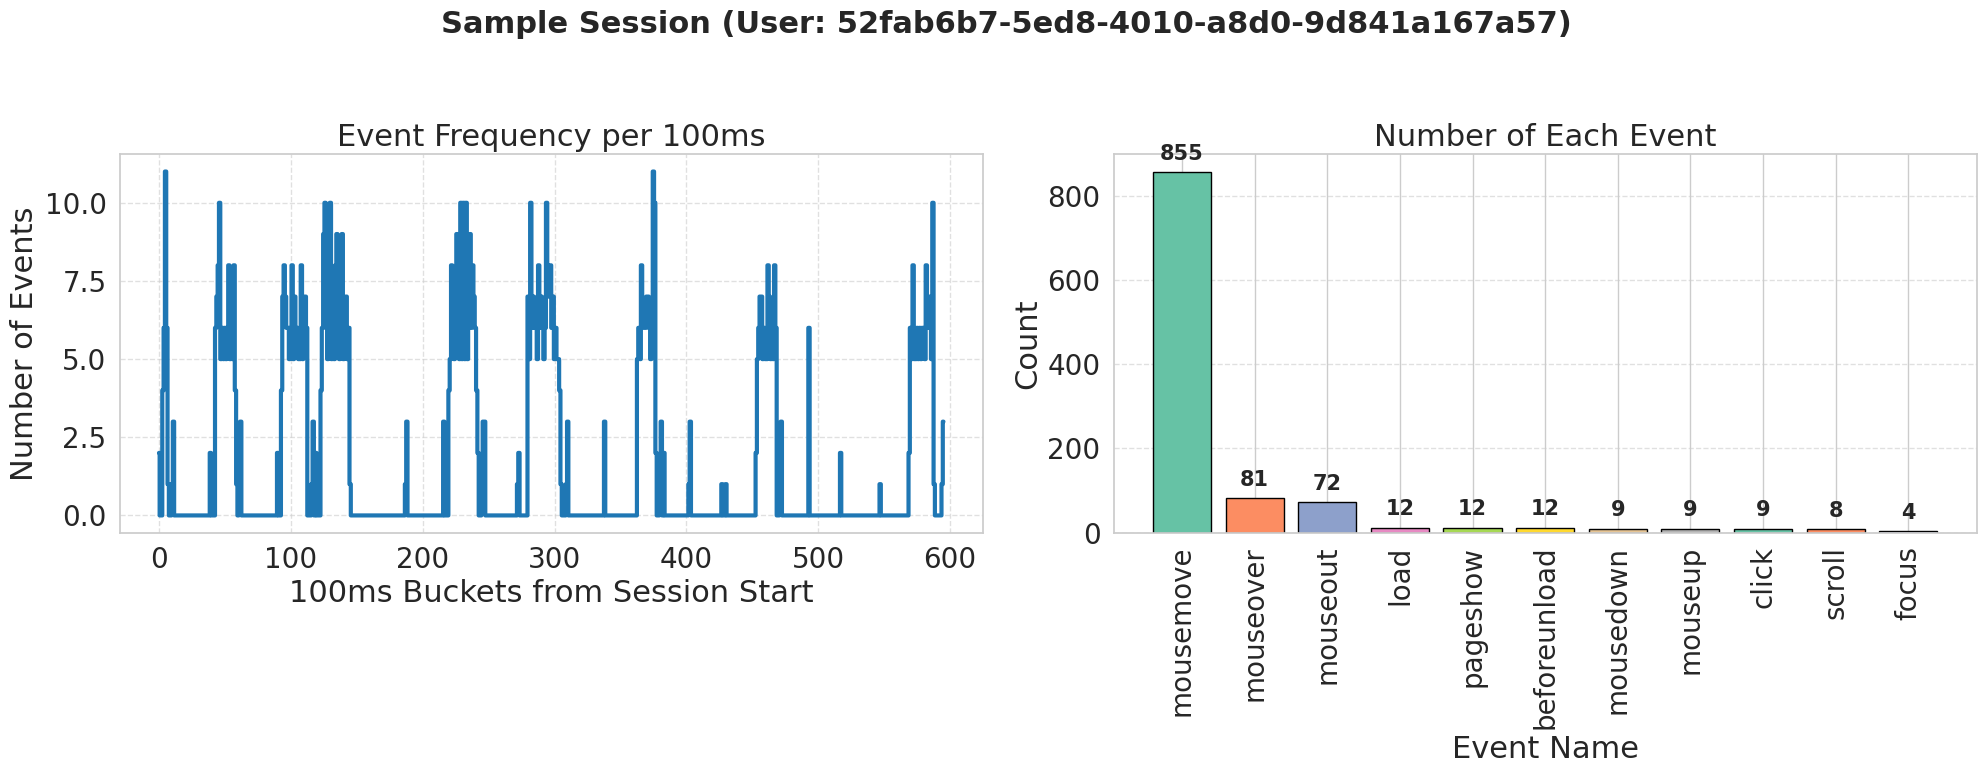

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


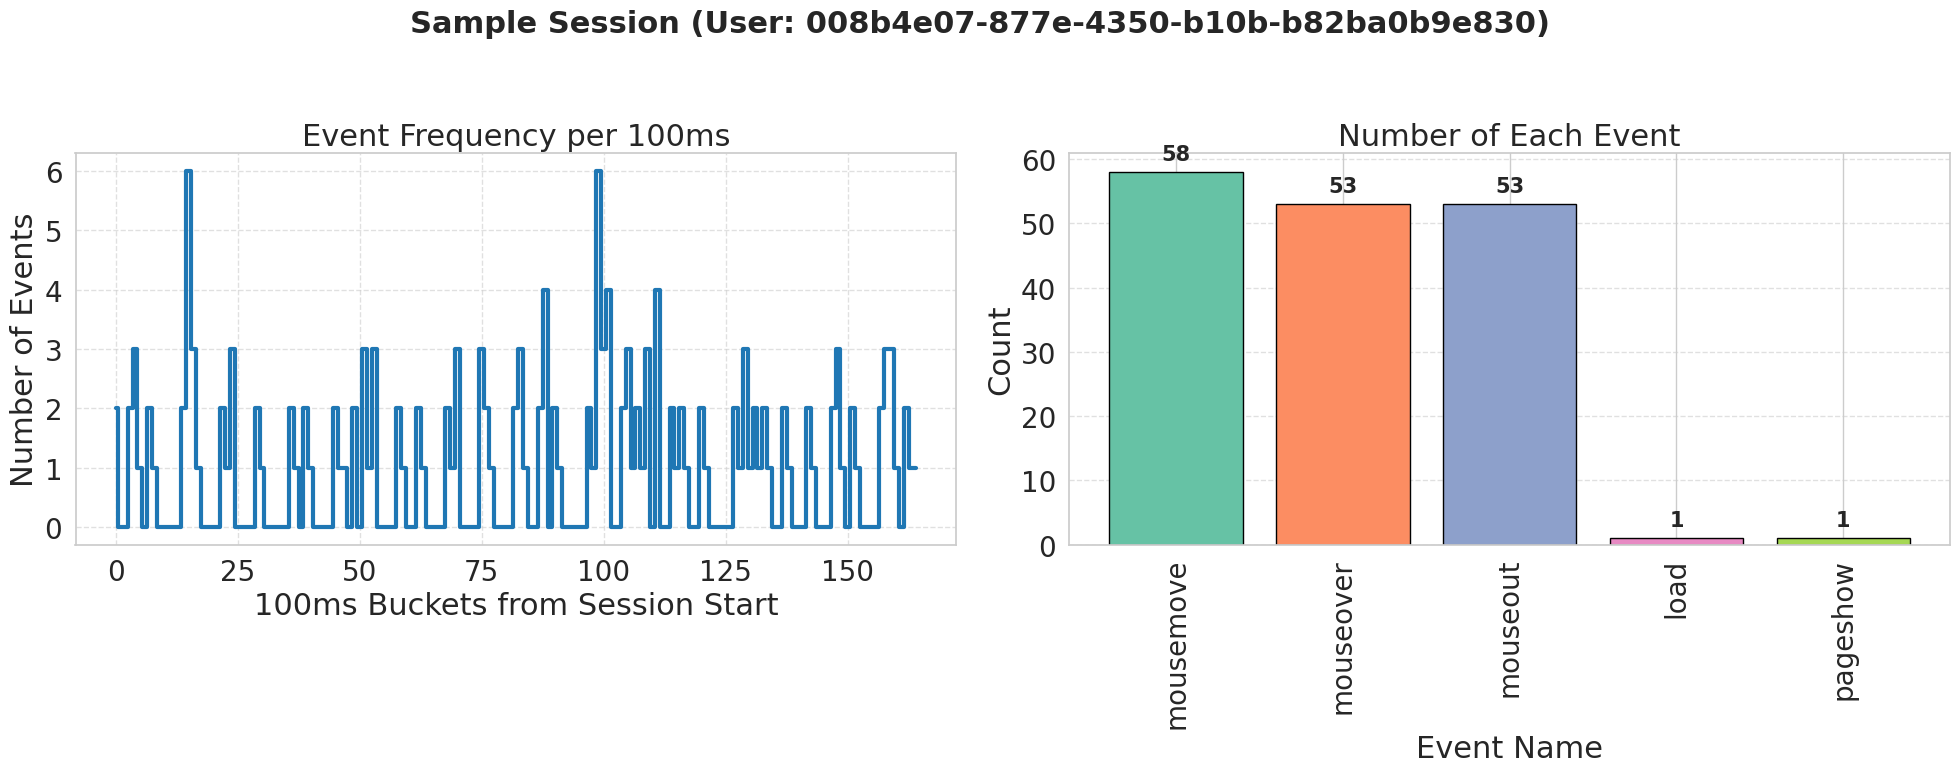

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


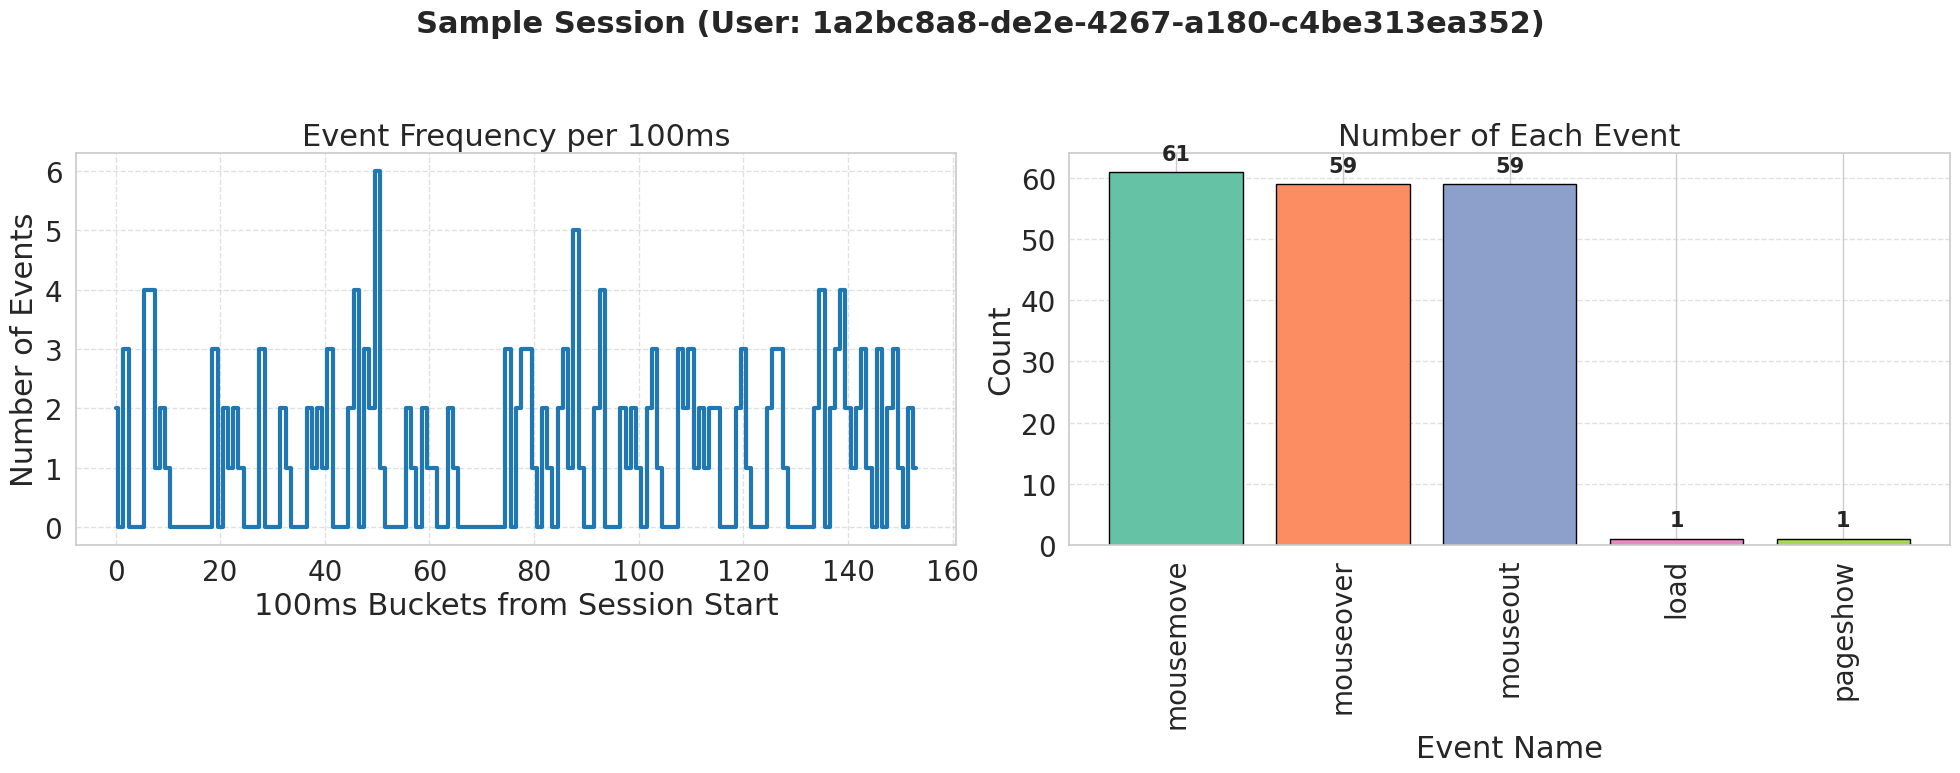

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


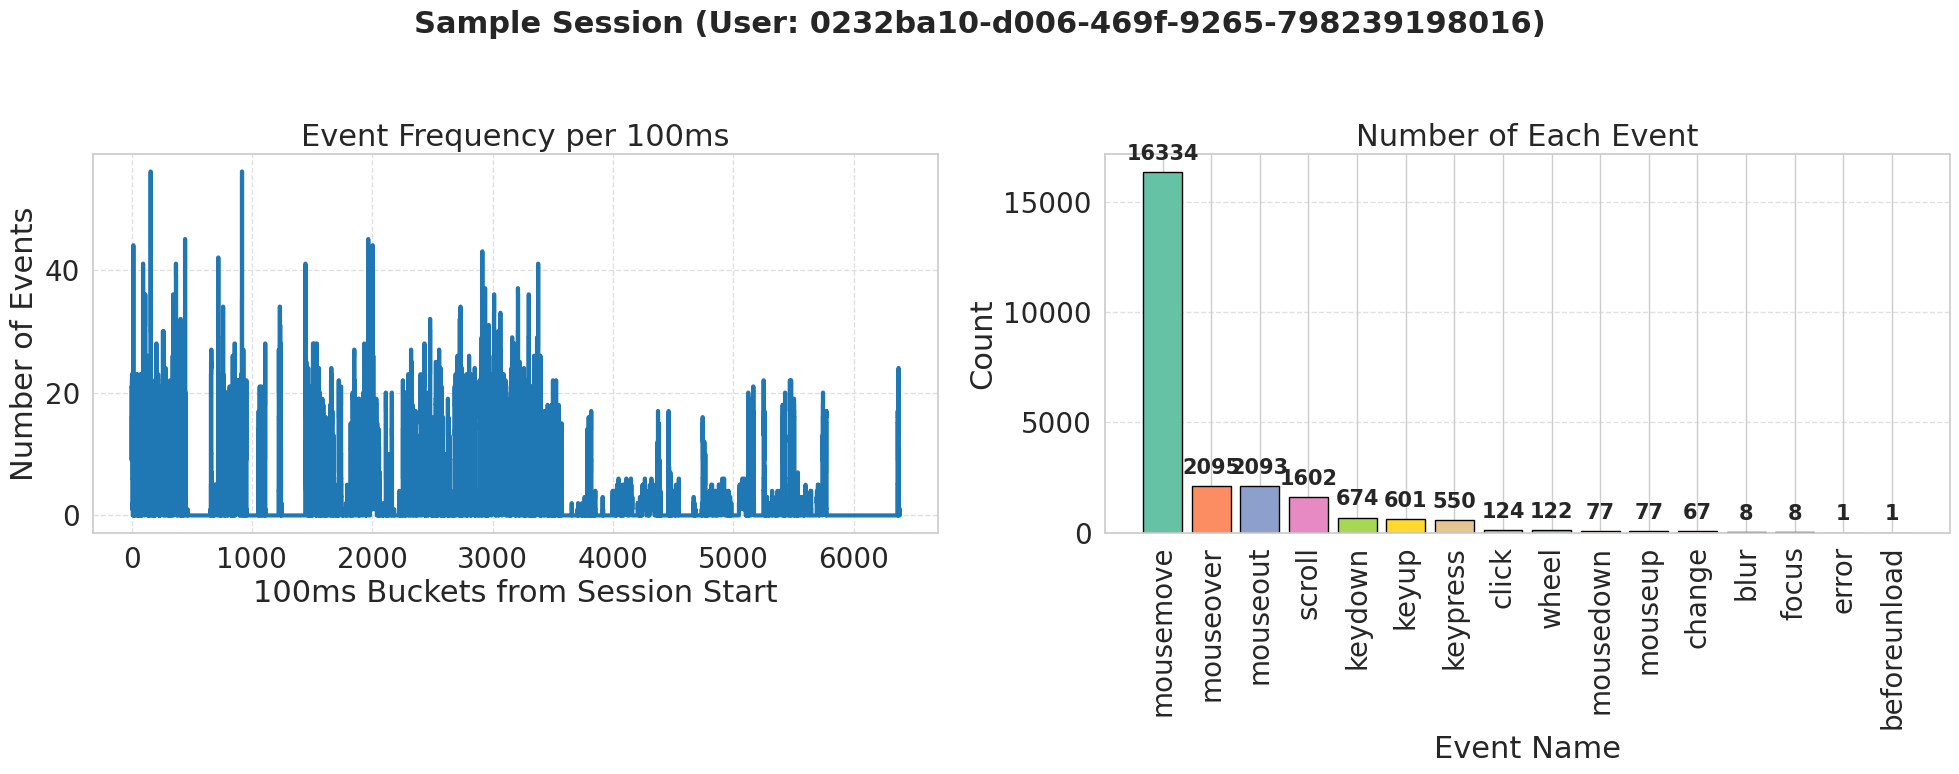

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


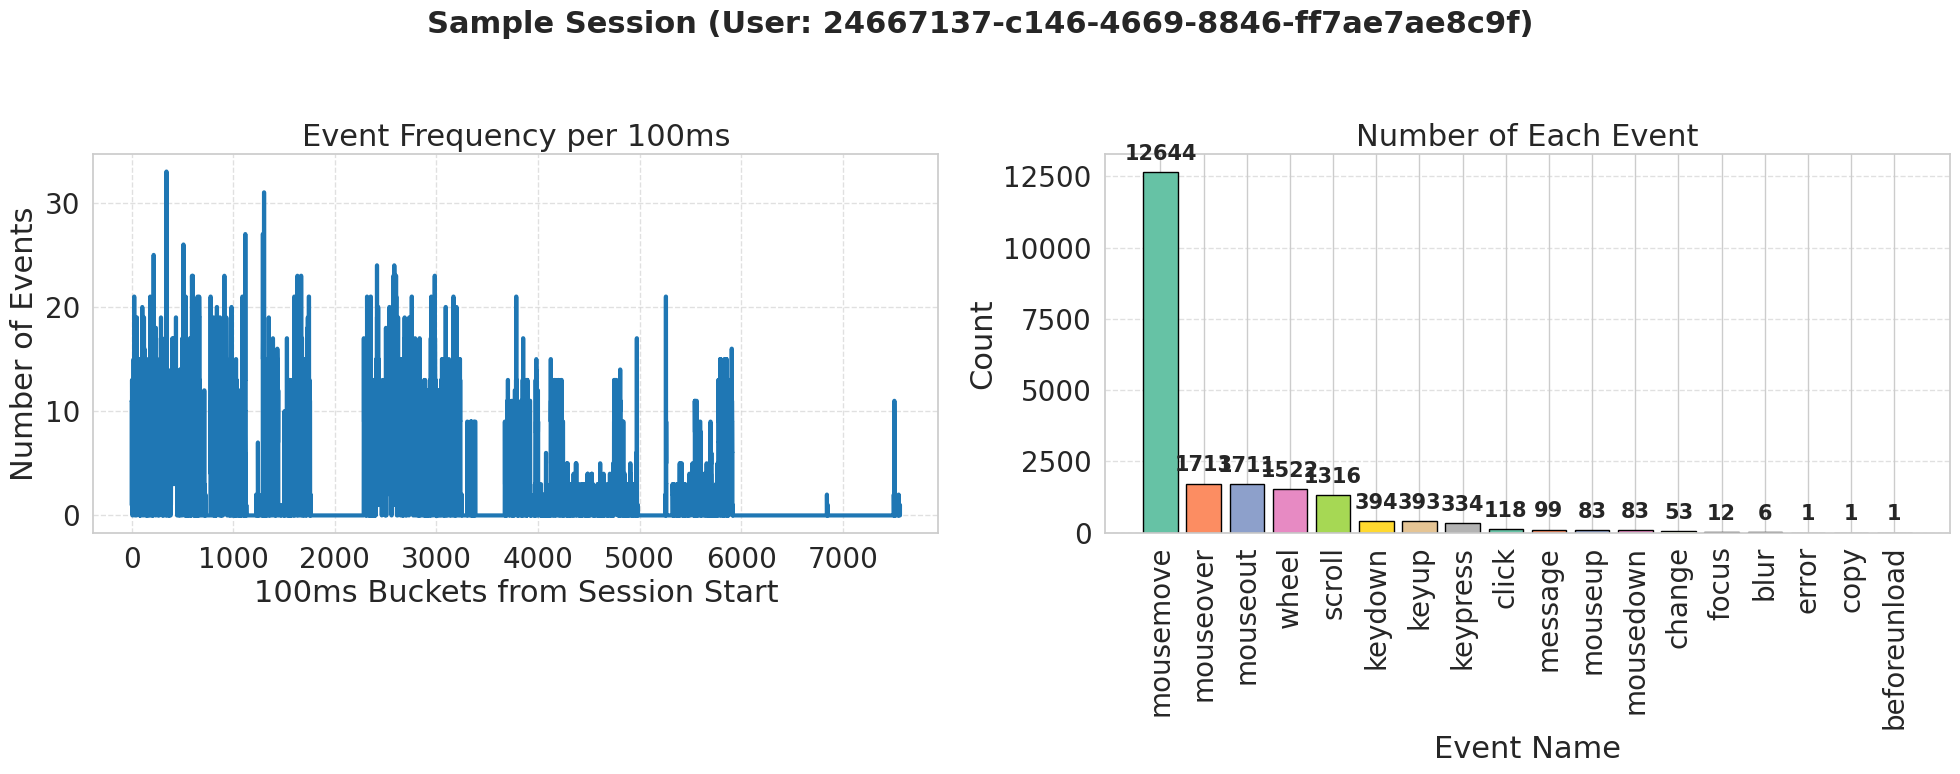

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


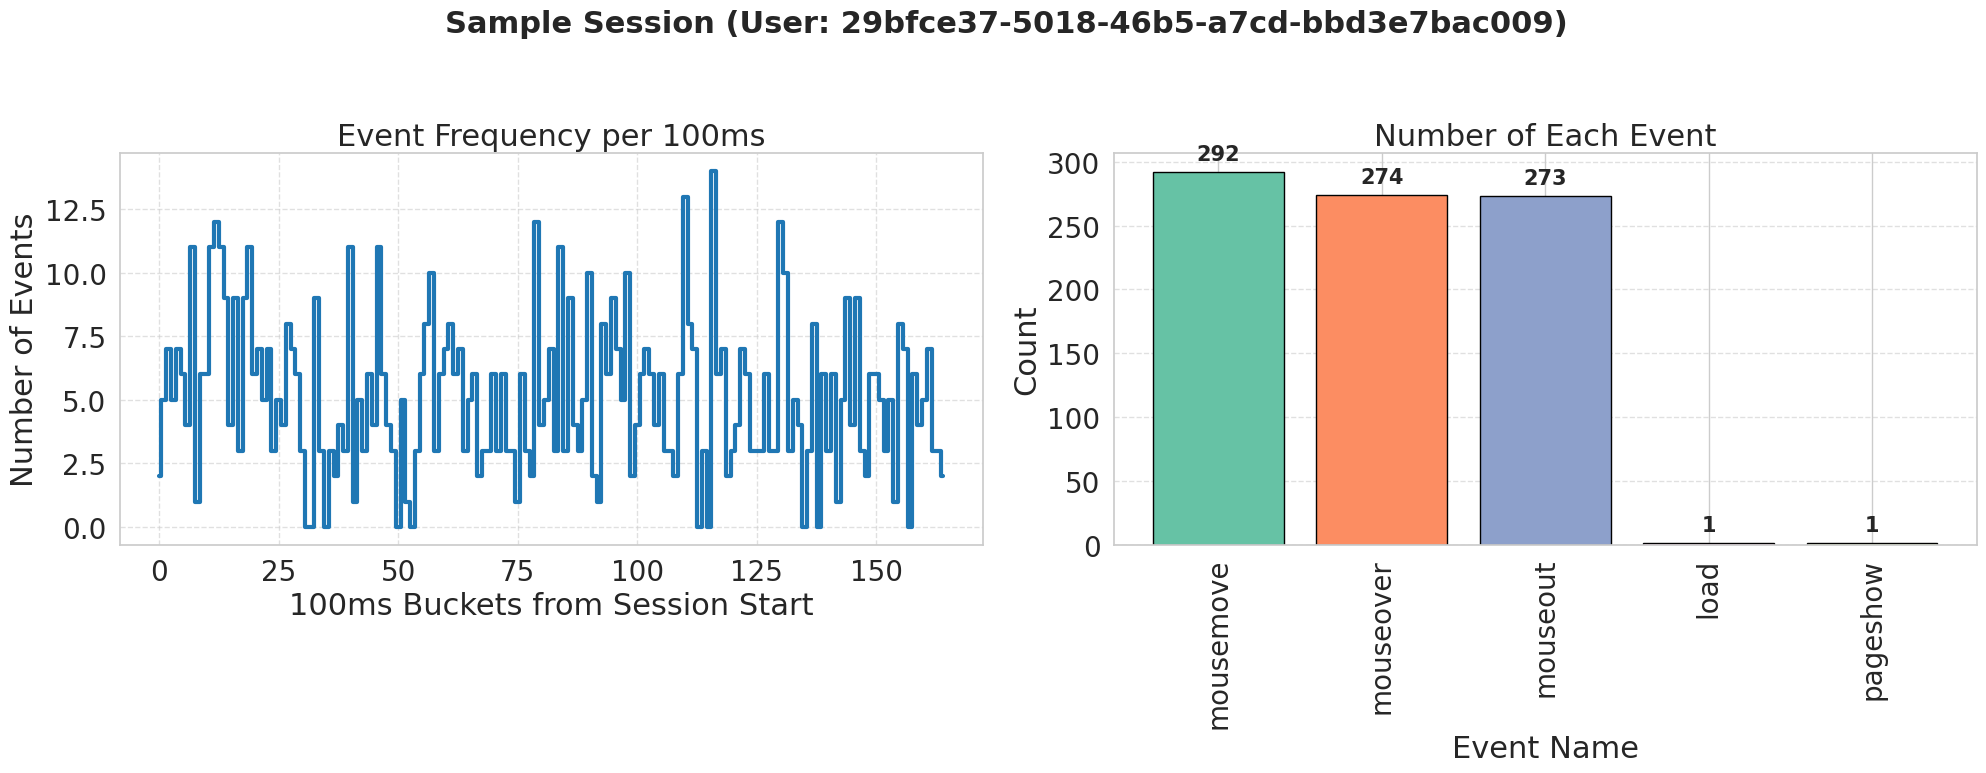

/tmp/ipykernel_4742/2550826090.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_per_bin = session.groupby('time_bin').size()


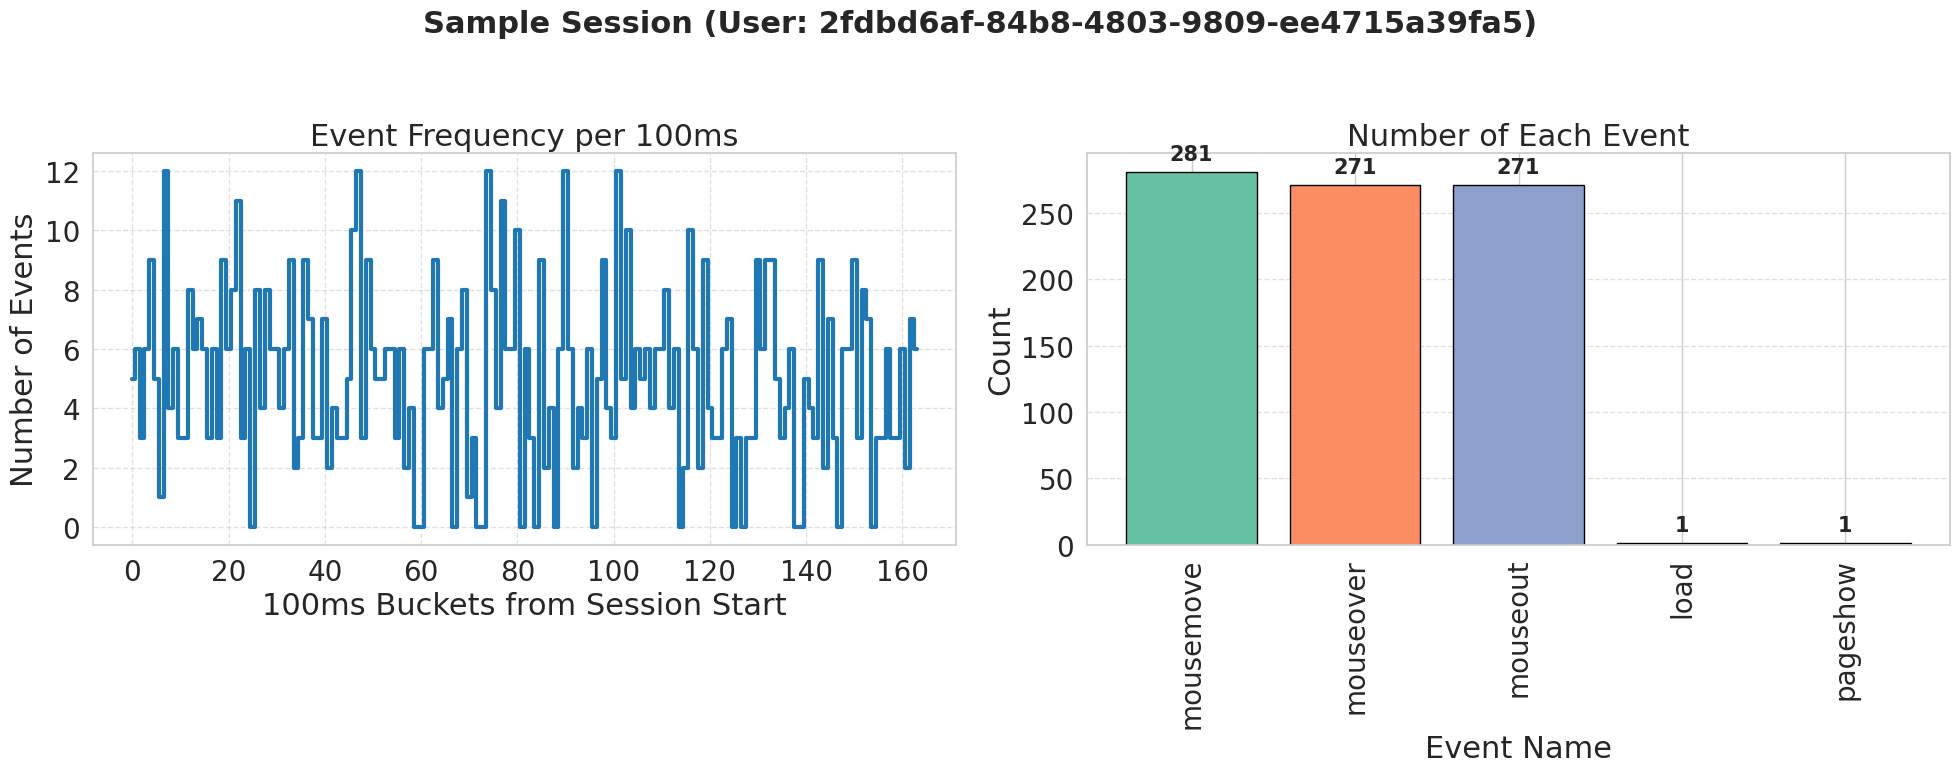

In [66]:
for k, _ in mixed_sample_events.items():
    plot_sample_sessions_side_by_side(k, mixed_sample_events[k]['events_df'])
